/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 57s 198ms/step - loss: 13206.2559 - val_loss: 5791.5562
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 49s 190ms/step - loss: 5546.8682 - val_loss: 4548.4697
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 47s 181ms/step - loss: 4930.7271 - val_loss: 4549.0386
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 45s 175ms/step - loss: 4848.1562 - val_loss: 4548.9277
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 81s 172ms/step - loss: 4807.2959 - val_loss: 3020.5784
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 84s 180ms/step - loss: 2965.0974 - val_loss: 2214.1428
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - loss: 2357.6978 - val_loss: 1711.0187
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 47s 181ms/step - loss: 1795.5944 - val_loss: 1488.1274
Epoch 9/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 180ms/step - loss: 1644.9869 - val_loss: 1429.4834
Epoch 10/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 90s 213ms/step - loss: 1622.0875 - val_loss: 1402.0977
Epoch 11/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 78s 199

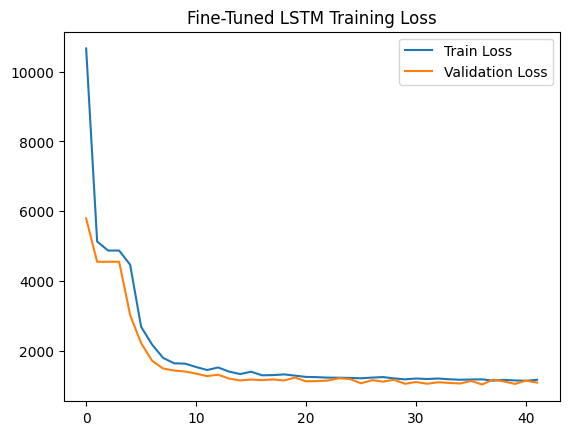

Fine-Tuned LSTM model predictions saved as 'fine_tuned_lstm_predictions.csv'


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv("/content/processed_turbofan_data.csv")

feature_cols = [col for col in data.columns if "sensor" in col]
features = data[feature_cols].values
labels = data["RUL"].values

scaler = MinMaxScaler()
features = scaler.fit_transform(features)

def create_sequences(data, labels, sequence_length=50):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(labels[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 50

X, y = create_sequences(features, labels, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(sequence_length, X.shape[2]))),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0005))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Fine-Tuned LSTM Model Performance:\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}\n")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Fine-Tuned LSTM Training Loss')
plt.show()

test_results = pd.DataFrame({
    "Actual RUL": y_test,
    "Fine-Tuned LSTM Prediction": y_pred.flatten()
})
test_results.to_csv("fine_tuned_lstm_predictions.csv", index=False)
print("Fine-Tuned LSTM model predictions saved as 'fine_tuned_lstm_predictions.csv'")